**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim  
import torchvision        
from torchvision import datasets, transforms
import matplotlib.pyplot as plt      
import numpy as np

**Configuration**

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

**Loss Function**

<img src="function.png" width="600">

**Discriminator Model**

In [3]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1,64,5,stride=2,padding=2)
        self.conv2 = nn.Conv2d(64,128,5,stride=2,padding=2)
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.drop_out = nn.Dropout(0.3)
        self.fc = nn.Linear(6272,1)

    def forward(self, input):
        # 28 x 28 - (1 Channel)
        output = self.conv1(input)
        output = self.leaky_relu(output)
        output = self.drop_out(output)
        # 14 x 14 - (64 Channel)
        output = self.conv2(output)
        output = self.leaky_relu(output)
        output = self.drop_out(output)
        # 7 x 7 - (128 Channel)
        output = output.view(output.size(0),1,-1)
        # 6272 Vector
        output = self.fc(output)
        output = torch.sigmoid(output)
        return output

**Generator Model**

In [4]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100,7*7*256,bias=False)
        self.bn0 = nn.BatchNorm1d(7*7*256)
        self.conv1 = nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(64,1,3,stride=1,padding=1,bias=False)
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        

    def forward(self, input):
        # 100 Vector
        output = self.fc(input)
        output = self.bn0(output)
        output = self.leaky_relu(output)
        # 7*7*256 Vector
        output = output.view(output.size(0),256,7,7)
        # 7 x 7 - (256 Channel)
        output = self.conv1(output)
        output = self.bn1(output)
        output = self.leaky_relu(output)
        # 7 x 7 - (128 Channel)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.leaky_relu(output)
        # 14 x 14 - (64 Channel)
        output = self.conv3(output)
        output = self.tanh(output)
        # 28 x 28 - (1 Channel)
        return output

**Model Initialization**

In [5]:
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

**Training Data**

In [6]:
train_batch_size = 64

transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,)) # Normalizing with mean and std deviat
])

train_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=train_batch_size,shuffle=True)

**Training Setup**

In [7]:
criterion = nn.BCELoss().to(DEVICE)
lr = 0.0001
real_label_value = 1.0
fake_label_value = 0.0

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

**Training**

/ext3/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch:  1


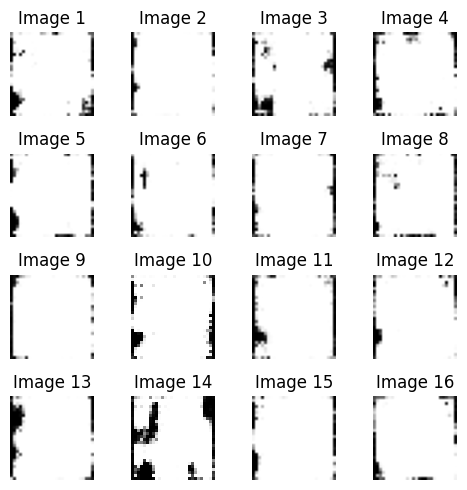

Epoch: 1, G_Loss: 0.7871, D_Loss: 1.3156, Average D(x): 0.5478, Average D(G(z)): 0.4549
Epoch:  11


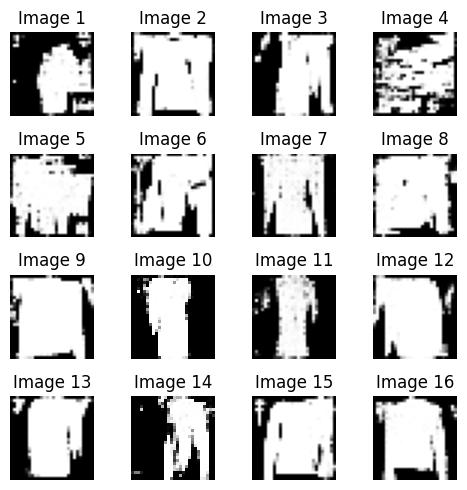

Epoch: 11, G_Loss: 1.0322, D_Loss: 1.1737, Average D(x): 0.5537, Average D(G(z)): 0.4465
Epoch:  21


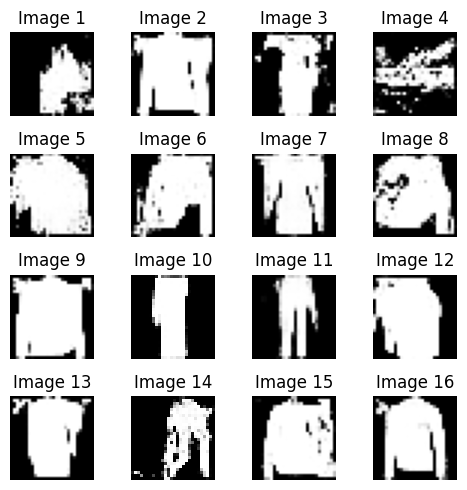

Epoch: 21, G_Loss: 0.8813, D_Loss: 1.2715, Average D(x): 0.5433, Average D(G(z)): 0.4562
Epoch:  31


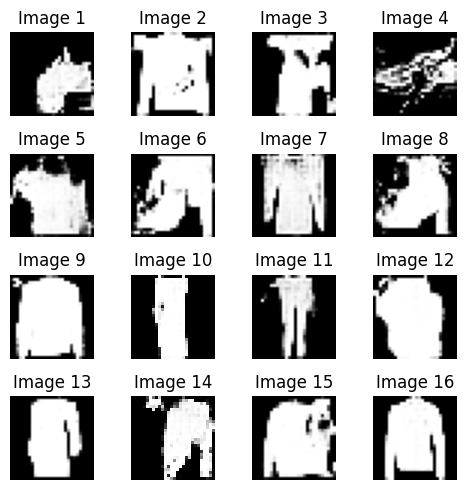

Epoch: 31, G_Loss: 0.7990, D_Loss: 1.4575, Average D(x): 0.5348, Average D(G(z)): 0.4648
Epoch:  41


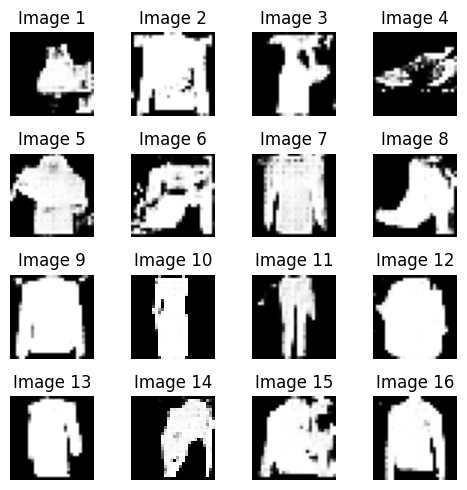

Epoch: 41, G_Loss: 0.8108, D_Loss: 1.3390, Average D(x): 0.5298, Average D(G(z)): 0.4697
Epoch:  50


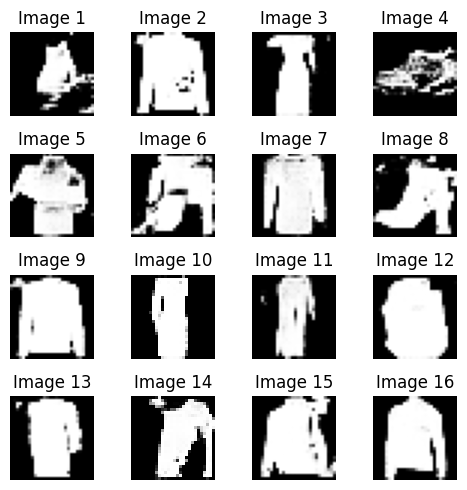

Epoch: 50, G_Loss: 0.8072, D_Loss: 1.3288, Average D(x): 0.5274, Average D(G(z)): 0.4721


In [8]:
num_epochs = 50
generator_loss_history = []
discriminator_loss_history = []
fixed_noise = torch.randn(16, 100, device=DEVICE)

for epoch in range(num_epochs):
    
    discriminator.train()
    generator.train()
    generator_total_loss = 0.0
    discriminator_total_loss = 0.0
    total_real_discriminator = 0.0
    total_fake_discriminator = 0.0
    n = 0

    for i, (real_batch, _) in enumerate(train_loader):
        
        batch_size = real_batch.size(0)
        n += batch_size

        # Discriminator Forward on Real Batch
        real_batch = real_batch.to(DEVICE)
        discriminator.zero_grad()
        discriminator_output = discriminator(real_batch).view(-1)
        total_real_discriminator += torch.sum(discriminator_output)
        real_label = torch.full((batch_size,), real_label_value, dtype=torch.float).to(DEVICE)
        
        # Discriminator Loss on Real Batch
        discriminator_real_loss = criterion(discriminator_output,real_label)
        discriminator_real_loss.backward()

        # Generator Forward on Latent Noise Vector
        noise = torch.rand(batch_size,100).to(DEVICE)
        fake_batch = generator(noise).to(DEVICE)

        # Discriminator Forward on Fake Batch
        discriminator_output = discriminator(fake_batch.detach()).view(-1)
        total_fake_discriminator += torch.sum(discriminator_output)
        fake_label = torch.full((batch_size,), fake_label_value, dtype=torch.float).to(DEVICE)

        # Discriminator Loss on Fake Batch
        discriminator_fake_loss = criterion(discriminator_output,fake_label)
        discriminator_fake_loss.backward()

        # Discriminator Backward
        discriminator_loss = discriminator_real_loss.item() + discriminator_fake_loss.item()
        discriminator_optimizer.step()

        # Generator Backward
        generator.zero_grad()
        discriminator_output = discriminator(fake_batch).view(-1)
        generator_loss = criterion(discriminator_output,real_label)
        generator_loss.backward()
        generator_optimizer.step()

    if i == len(train_loader) - 1:
        generator_loss_history.append(generator_loss)
        discriminator_loss_history.append(discriminator_loss)
            
    if (epoch%10==0 or epoch == 49) and i == len(train_loader) - 1:
        generator.eval()
        output = generator(fixed_noise)
        output = output.view(16, 28, 28)
        output = output.detach().cpu().numpy()

        generator_loss_history.append(generator_loss)
        discriminator_loss_history.append(discriminator_loss)
        
        plt.figure(figsize=(5, 5))
        print("Epoch: ", epoch+1)
        for i in range(16):
            current_output = output[i]
            plt.subplot(4, 4, i + 1)
            plt.imshow(output[i], cmap='gray')
            plt.axis('off')
            plt.title(f'Image {i + 1}')
        
        plt.tight_layout()  # Adjust layout
        plt.show()

        
        print(f"Epoch: {epoch+1}, G_Loss: {generator_loss:.4f}, D_Loss: {discriminator_loss:.4f}, "
          f"Average D(x): {total_real_discriminator/n:.4f}, Average D(G(z)): {total_fake_discriminator/n:.4f}")

In [9]:
generator_loss_history = [loss.cpu().item() for loss in generator_loss_history]
generator_loss_history = np.array(generator_loss_history)

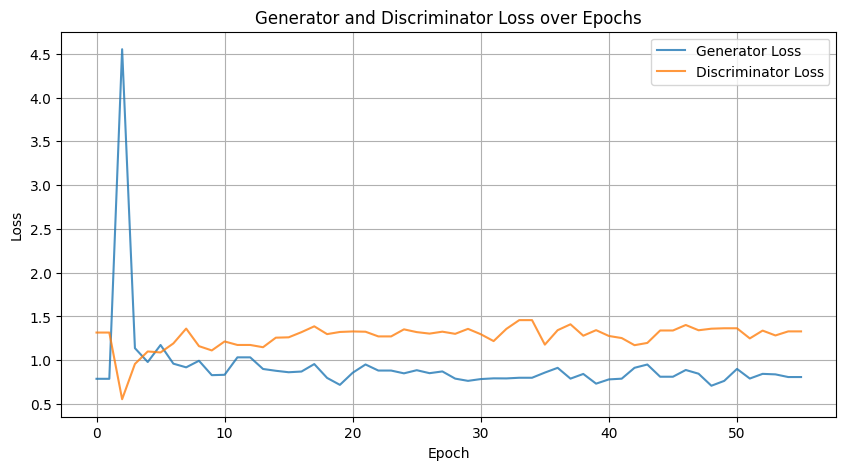

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss', alpha=0.8)
plt.plot(discriminator_loss_history, label='Discriminator Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()